In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import tensorflow as tf
import os
import pickle
import json
import re

In [2]:
tf.test.is_gpu_available()

True

In [3]:
# create giant dictionary for all data
data_dir = '../facebook_challenge_data/'
model_dir = 'models/'

# load data and print sizes
def get_dict(path):
    jsonl_content = open(path, 'r').read()
    data = [json.loads(jline) for jline in jsonl_content.split('\n')]
    return {datum['id'] : datum for datum in data}


train_dict = get_dict(data_dir + 'train.jsonl')
val_dict = get_dict(data_dir + 'dev.jsonl')
test_dict = get_dict(data_dir + 'test.jsonl')

print(len(train_dict))
print(len(val_dict))
print(len(test_dict))

8500
500
1000


In [4]:
# transform from json dictionaries to dataset
def get_text_data(dictionary):
    return [(datum['text'], datum['label']) for datum in dictionary.values()]

train_data = get_text_data(train_dict)
val_data = get_text_data(val_dict)
# test_list = get_text_data(test_dict)

In [5]:
# make the dataset
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, TFRobertaModel

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
MAX_SEQ_LEN = 50

# training
texts, labels = zip(*train_data)
print('Longest training sequence length:', max([len(t.split()) for t in texts]))

sequences = [tokenizer.encode(text) for text in texts]

x_train = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

y_train = np.asarray(labels)
print('Shape of data tensor:', x_train.shape)
print('Shape of label tensor:', y_train.shape)

# validation
val_texts, val_labels = zip(*val_data)

val_sequences = [tokenizer.encode(text) for text in val_texts]
x_val = pad_sequences(val_sequences, maxlen=MAX_SEQ_LEN)
y_val = np.asarray(val_labels)

Longest training sequence length: 70
Shape of data tensor: (8500, 50)
Shape of label tensor: (8500,)


In [6]:
# load pretrained roberta
import transformers
from tensorflow.keras import layers

class ROBERTA(transformers.TFRobertaModel):

    def __init__(self, config, *inputs, **kwargs):
        super(ROBERTA, self).__init__(config, *inputs, **kwargs)
        self.roberta.call = tf.function(self.roberta.call)

input_ids = layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32)
roberta = ROBERTA.from_pretrained('roberta-base')
roberta_encodings = roberta([input_ids])[0]
doc_encoding = tf.squeeze(roberta_encodings[:, 0:1, :], axis=1) # Keep [CLS] token encoding
doc_encoding = layers.Dropout(0.1)(doc_encoding) # Apply dropout
outputs = layers.Dense(1, activation='sigmoid', name='outputs')(doc_encoding)
model = tf.keras.models.Model(inputs=[input_ids], outputs=[outputs])

# compile
optimizer = tf.keras.optimizers.Adam(lr=5e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
roberta (ROBERTA)            ((None, 50, 768), (None,  124645632 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1, 768)]          0         
_________________________________________________________________
tf_op_layer_Squeeze (TensorF [(None, 768)]             0         
_________________________________________________________________
dropout_38 (Dropout)         (None, 768)               0         
_________________________________________________________________
outputs (Dense)              (None, 1)                 769       
Total params: 124,646,401
Trainable params: 124,646,401
Non-trainable params: 0
_______________________________________________

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint(model_dir + 'best_text_roberta_weights.h5', 
                           save_weights_only=True, 
                           save_best_only=True, 
                           verbose=1,
                           monitor='val_loss', 
                           mode='min')


history = model.fit(x_train, y_train, epochs=5, batch_size=100, validation_data=(x_val, y_val), callbacks=[mcp_save])

Train on 8500 samples, validate on 500 samples
Epoch 1/5
8400/8500 [============================>.] - ETA: 1s - loss: 0.6510 - accuracy: 0.6424
Epoch 00001: val_loss improved from inf to 0.68558, saving model to models/best_text_roberta_weights.h5
8500/8500 [==============================] - 170s 20ms/sample - loss: 0.6515 - accuracy: 0.6418 - val_loss: 0.6856 - val_accuracy: 0.5720
Epoch 2/5
8400/8500 [============================>.] - ETA: 1s - loss: 0.5865 - accuracy: 0.7152
Epoch 00002: val_loss did not improve from 0.68558
8500/8500 [==============================] - 146s 17ms/sample - loss: 0.5870 - accuracy: 0.7146 - val_loss: 0.7165 - val_accuracy: 0.5700
Epoch 3/5
8400/8500 [============================>.] - ETA: 1s - loss: 0.5455 - accuracy: 0.7337
Epoch 00003: val_loss did not improve from 0.68558
8500/8500 [==============================] - 147s 17ms/sample - loss: 0.5460 - accuracy: 0.7331 - val_loss: 0.7792 - val_accuracy: 0.5580
Epoch 4/5
8400/8500 [=====================

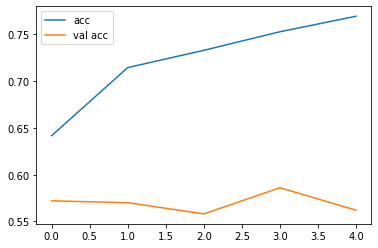

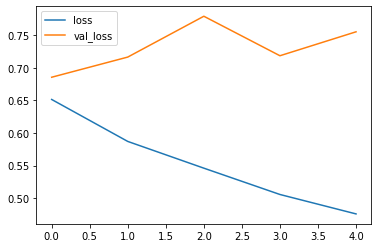

In [8]:
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [9]:
model.load_weights(model_dir + 'best_text_roberta_weights.h5')

In [10]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score

val_texts, val_labels = zip(*val_data)

val_sequences = [tokenizer.encode(text) for text in val_texts] # apply train tokenizer
x_val = pad_sequences(val_sequences, maxlen=MAX_SEQ_LEN)
y_val = np.asarray(val_labels)

# get AUROC
preds = model.predict(x_val)
print('Test AUROC:', roc_auc_score(y_val, preds))

# get loss and acc
preds_bin = np.array(preds)
preds_bin[preds >= 0.5] = 1
preds_bin[preds < 0.5] = 0
print('Val acc:', accuracy_score(y_val, preds_bin))

# get F1
print('Val F1:', f1_score(y_val, preds_bin, zero_division=1))
print('Val Precision:', precision_score(y_val, preds_bin, zero_division=1))
print('Val Recall:', recall_score(y_val, preds_bin, zero_division=1))

Test AUROC: 0.609776
Val acc: 0.572
Val F1: 0.5046296296296297
Val Precision: 0.5989010989010989
Val Recall: 0.436


In [11]:
# import pickle

# model.save(model_dir + 'fb_lstm.h5')
# pickle.dump(tokenizer, open(model_dir + 'fb_tokenizer.pkl', 'wb'))

In [12]:
jsonl_content = open(data_dir + 'test.jsonl', 'r').read()
data = [json.loads(jline) for jline in jsonl_content.split('\n')]
test_data = [(d['id'], d['text']) for d in data]
ids, test_texts = zip(*test_data)

test_sequences = [tokenizer.encode(text) for text in test_texts] # apply train tokenizer
x_test = pad_sequences(test_sequences, maxlen=MAX_SEQ_LEN)

preds = model.predict(x_test)
preds = np.squeeze(preds)
# print(preds)

preds_bin = np.array(preds)
preds_bin[preds >= 0.5] = 1
preds_bin[preds < 0.5] = 0

# write to csv
import csv

with open('roberta_text_submission.csv', 'w') as myfile:
    wr = csv.writer(myfile)
    wr.writerow(["id", "proba", "label"])
    for ID, prob, lab in zip(ids, preds, preds_bin):
        ID = '0' * (5-len(str(ID))) + str(ID)
        wr.writerow([ID, prob, int(lab)])